# Classifying Business Documents using Deep Learning
## IBM Coursera Advanced Data Science Capstone - Results Demo

## Sumudu Tennakoon

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import re
import matplotlib.pyplot as plt 
from datetime import date
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
print('TensorFlow Version: ', tf.__version__)

from DocumentClassifierV1 import * # Custom library created for the Capstone project.

TensorFlow Version:  1.12.0


## 1. Read Pre-saved Input dataset (Test Sample-not used in modeling)

In [2]:
DocumentFilesData  = pd.read_pickle('Data/DocumentClassification_IBM_ADV_DS_Capstone_TestSample_128x128_20190316.pkl')

## 2. Organize Classs Labels

In [3]:
ClassLabels = list(DocumentFilesData.FileClass.unique()) 

In [4]:
ClassNumbers = list(range(len(ClassLabels)))

In [5]:
ClassLabelMap = list((zip(ClassLabels, ClassNumbers)))
print(ClassLabelMap)

[('advertisement', 0), ('handwritten', 1), ('invoice', 2), ('letter', 3), ('resume', 4), ('scientific publication', 5)]


In [6]:
for clm in ClassLabelMap:
    DocumentFilesData.loc[DocumentFilesData['FileClass']==clm[0] , 'ClassNumber'] = clm[1]

## 3. Separate Features and Response

In [7]:
NClasses = len(ClassLabels)
imgRows = 128
imgCols = 128  

In [8]:
X = np.asarray(list(DocumentFilesData['DocumentMatrix'].values), dtype ='int')
y = DocumentFilesData['ClassNumber'].values

In [9]:
#Shape of datasets
print(X.shape)
print(y.shape)

(16298, 128, 128)
(16298,)


## 4. Plot sample image

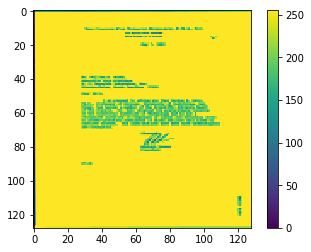

In [10]:
#Plot sample image with scale
plt.imshow(X[10000])
plt.colorbar()

## 5. Send data into the Model

In [11]:
if keras.backend.image_data_format() == 'channels_first':
    X = X.reshape(X.shape[0], 1, imgRows, imgCols)
    input_shape = (1, imgRows, imgCols)
else:
    X = X.reshape(X.shape[0], imgRows, imgCols, 1)
    input_shape = (imgRows, imgCols, 1)

In [12]:
X = X.astype('float32') #convert interger image tensor to float
X = X/255 # Normalize grayscale to a number between 0 and 1
print(X.shape[0], 'samples')
# Record actuals
y_act = y

16298 samples


In [13]:
y = keras.utils.to_categorical(y, NClasses)

In [14]:
ClassificationModel = TFModel(ModelFile='Models/DocumentClassification_IBM_ADV_DS_Capstone_CNN_V03_128x128_20190316.pkl', Model=keras.models.load_model('Models/DocumentClassification_IBM_ADV_DS_Capstone_CNN_V03_128x128_20190316.h5'))

In [15]:
Output = ClassificationModel.Classify(InputFiles=X, size=(imgRows,imgCols), ActualClasses=list(y_act),
                                      ReturnImageMatrix=True, ReturnJSON=False, ReturnFullPath=True, TransformedData=True)

## 6. Proces output

In [16]:
Output['actual'] = Output['actual'].astype('int')

In [17]:
for clm in ClassLabelMap:
    Output.loc[Output['actual']==clm[1] , 'actual'] = clm[0]

In [18]:
Output.head()

,filename,actual,prediction,probability,advertisement,handwritten,invoice,letter,resume,scientific publication,image
0,,advertisement,advertisement,1.000000,1.000000,5.063637e-16,8.690148e-14,9.290668e-17,6.617022e-21,4.106039e-14,"[[1.0, 1.0, 1.0, 1.0, 0.99215686, 0.972549, 0...."
1,,advertisement,advertisement,1.000000,1.000000,2.330656e-22,1.572528e-19,2.069340e-23,1.100756e-29,2.149585e-21,"[[1.0, 1.0, 0.99607843, 1.0, 1.0, 0.99607843, ..."
2,,advertisement,advertisement,1.000000,1.000000,4.791157e-16,5.554594e-13,1.064234e-16,1.399147e-19,2.178409e-15,"[[0.3372549, 0.92156863, 1.0, 1.0, 1.0, 1.0, 1..."
3,,advertisement,advertisement,1.000000,1.000000,4.083911e-11,3.346294e-11,1.050855e-11,3.322009e-14,3.328225e-10,"[[0.6039216, 0.6509804, 0.65882355, 0.6392157,..."
4,,advertisement,advertisement,0.999995,0.999995,8.333130e-07,3.941132e-06,2.784736e-08,8.344550e-09,3.533234e-07,"[[1.0, 1.0, 0.99215686, 0.98039216, 1.0, 1.0, ..."


## 7. Performance Evaluation

### Confusion Matrix

In [19]:
cf = pd.crosstab(Output.actual, Output.prediction, margins=True)

In [20]:
cf

prediction,advertisement,handwritten,invoice,letter,resume,scientific publication,All
actual,,,,,,,
advertisement,2430,23,73,13,5,63,2607
handwritten,27,2375,96,47,13,17,2575
invoice,41,56,2545,142,22,34,2840
letter,22,51,180,2437,75,67,2832
resume,2,9,37,109,2455,35,2647
scientific publication,35,9,75,41,30,2607,2797
All,2557,2523,3006,2789,2600,2823,16298


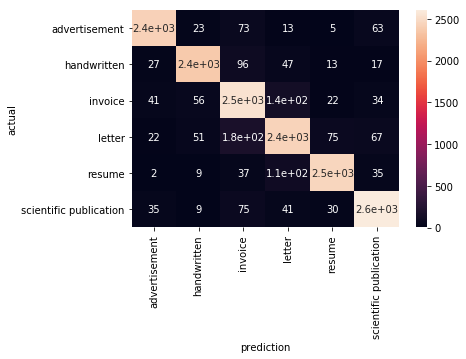

In [21]:
import seaborn as sns
sns.heatmap(pd.crosstab(Output.actual, Output.prediction, margins=False), annot=True)

### Accuracy

In [22]:
CorrectPredictions = np.sum(np.diagonal(pd.crosstab(Output.actual, Output.prediction, margins=False).values))
TotalDocuments = np.sum(pd.crosstab(Output.actual, Output.prediction, margins=False).values)
Accuracy = CorrectPredictions/TotalDocuments
print('CorrectPredictions= {}'.format(CorrectPredictions))
print('TotalDocuments= {}'.format(TotalDocuments))
print('Accuracy= {}'.format(Accuracy))

CorrectPredictions= 14849
TotalDocuments= 16298
Accuracy= 0.9110933856914959


### Model Robustness

In [23]:
bins=np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
labels=np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
Output['MaxProbabilityScore']=pd.cut(Output.probability, bins=bins) #, labels=labels)
Output['PredictedCorrect'] = np.where(Output['actual']==Output['prediction'], 1, 0)

Robustness = Output.groupby(by='MaxProbabilityScore').agg({'probability':'mean', 'PredictedCorrect':'sum', 'filename':'count'})
Robustness.columns = ['MeanProbability', 'PredictedCorrect', 'BucketCount']
Robustness['BucketPrecision']=Robustness['PredictedCorrect']/Robustness['BucketCount']
Robustness['BucketFraction']=Robustness['BucketCount']/(Robustness['BucketCount'].sum())

In [24]:
Robustness

,MeanProbability,PredictedCorrect,BucketCount,BucketPrecision,BucketFraction
MaxProbabilityScore,,,,,
"(0.0, 0.1]",NaN,0,0,NaN,0.000000
"(0.1, 0.2]",NaN,0,0,NaN,0.000000
"(0.2, 0.3]",0.295488,1,1,1.000000,0.000061
"(0.3, 0.4]",0.364005,5,27,0.185185,0.001657
"(0.4, 0.5]",0.452881,37,91,0.406593,0.005584
"(0.5, 0.6]",0.546791,81,215,0.376744,0.013192
"(0.6, 0.7]",0.651152,99,198,0.500000,0.012149
"(0.7, 0.8]",0.753281,119,230,0.517391,0.014112
"(0.8, 0.9]",0.856049,215,371,0.579515,0.022764


## 8. Run the model on sample Image file


In [25]:
InputFiles = ['Data/test1.png']
Output_single = ClassificationModel.Classify(InputFiles=InputFiles, size=(imgRows,imgCols), ActualClasses=None,
                                  ReturnImageMatrix=True, ReturnJSON=True, ReturnFullPath=False, TransformedData=False)

In [26]:
Output_single

[{'filename': 'test1.png',
  'actual': None,
  'prediction': 'letter',
  'probability': 0.8929004,
  'classes': [{'class': 'advertisement', 'score': 2.2899491e-09},
   {'class': 'handwritten', 'score': 3.0054548e-07},
   {'class': 'invoice', 'score': 3.233218e-08},
   {'class': 'letter', 'score': 0.8929004},
   {'class': 'resume', 'score': 0.00031701275},
   {'class': 'scientific publication', 'score': 0.10678229}],
  'image': array([[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)}]

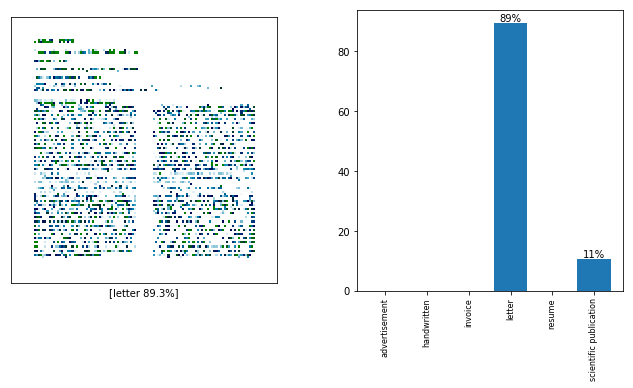

In [27]:
OutputDashboard = Dashboard()
fig = OutputDashboard.ImageOutput(Output_single, NSamples=1, Format='JSON', ClassLabels=ClassificationModel.ClassLabels)
plt.show()

<hr>
<p> This notebook and related materials were developed by <b> Sumudu Tennakoon</b> for the capstone project in partial fulfillment of the requirements for the <b> Advanced Data Science with IBM Specialization</b>. <br>
March 2019. <br>
Apache License, Version 2.0 (http://www.apache.org/licenses/LICENSE-2.0)</p>
